**Principal Components Analisis**

In [63]:
# load data
import pandas as pd
df = pd.read_csv("ames.csv")
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,3,2010,WD,Normal,189900


In [64]:
# features
features = ['GarageArea', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea']
print(f"Correlation with SalePrice:\n{df[features].corrwith(df.SalePrice)}")

Correlation with SalePrice:
GarageArea      0.640138
YearRemodAdd    0.532974
TotalBsmtSF     0.632529
GrLivArea       0.706780
dtype: float64


In [65]:
# Apply PCA and extract loadings
import numpy as np
from pandas import DataFrame
from sklearn.decomposition import PCA


X = df.copy()
y = X.pop('SalePrice')
X = X.loc[:, features]

def apply_pca(X: DataFrame, standardize=True) -> tuple[PCA, pd.DataFrame, pd.DataFrame] :
  if standardize:
    X = (X - X.mean(axis=0)) / X.std(axis=0)
  pca = PCA()
  x_pca = pca.fit_transform(X)
  component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
  x_pca = pd.DataFrame(x_pca, columns=component_names)
  loadings = pd.DataFrame(pca.components_.T, columns=component_names, index=X.columns)
  return pca, x_pca, loadings
  

pca, X_pca, loadings = apply_pca(X)
print(loadings)

                   PC1       PC2       PC3       PC4
GarageArea    0.541229  0.102375 -0.038470  0.833733
YearRemodAdd  0.427077 -0.886612 -0.049062 -0.170639
TotalBsmtSF   0.510076  0.360778 -0.666836 -0.406192
GrLivArea     0.514294  0.270700  0.742592 -0.332837


In [66]:
# Intercept component loadings


In [67]:
# features with potencial
import numpy as np
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(x: pd.DataFrame, y: pd.Series):
  x = x.copy()
  for colname in x.select_dtypes(['object', 'category']):
    x[colname], _ = x[colname].factorize()
  discrete_features = [pd.api.types.is_integer_dtype(t) for t in x.dtypes]
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
  mi_scores = pd.Series(mi_scores, name='MI Scores', index=x.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

mi_scores = make_mi_scores(X, y)
mi_scores

GrLivArea       0.497836
GarageArea      0.418882
TotalBsmtSF     0.392234
YearRemodAdd    0.316050
Name: MI Scores, dtype: float64

In [68]:
# Create new features (USING loadings)
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor


X = df.copy()
y = X.pop('SalePrice')

X['Feature1'] = X.GrLivArea + X.TotalBsmtSF
X['Feature2'] = X.YearRemodAdd * X.TotalBsmtSF

def score_dataset(X, y, model=XGBRegressor()):
  for colname in X.select_dtypes(['category', 'object']):
    X[colname], _ = X[colname].factorize()
  score_val = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_log_error')
  mean = -1 * score_val.mean()
  score = np.sqrt(mean)
  return score

score = score_dataset(X, y)
print(f"Score: {score:.5f} RMSLE")

Score: 0.13792 RMSLE


In [69]:
# Create new features (using components)
X_1 = df.copy()
y = X_1.pop('SalePrice')

X_1 = X_1.join(X_pca)
score = score_dataset(X_1, y)
print(f"Score: {score:.5f} RMSLE")

Score: 0.13856 RMSLE


/Users/asaucedov/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


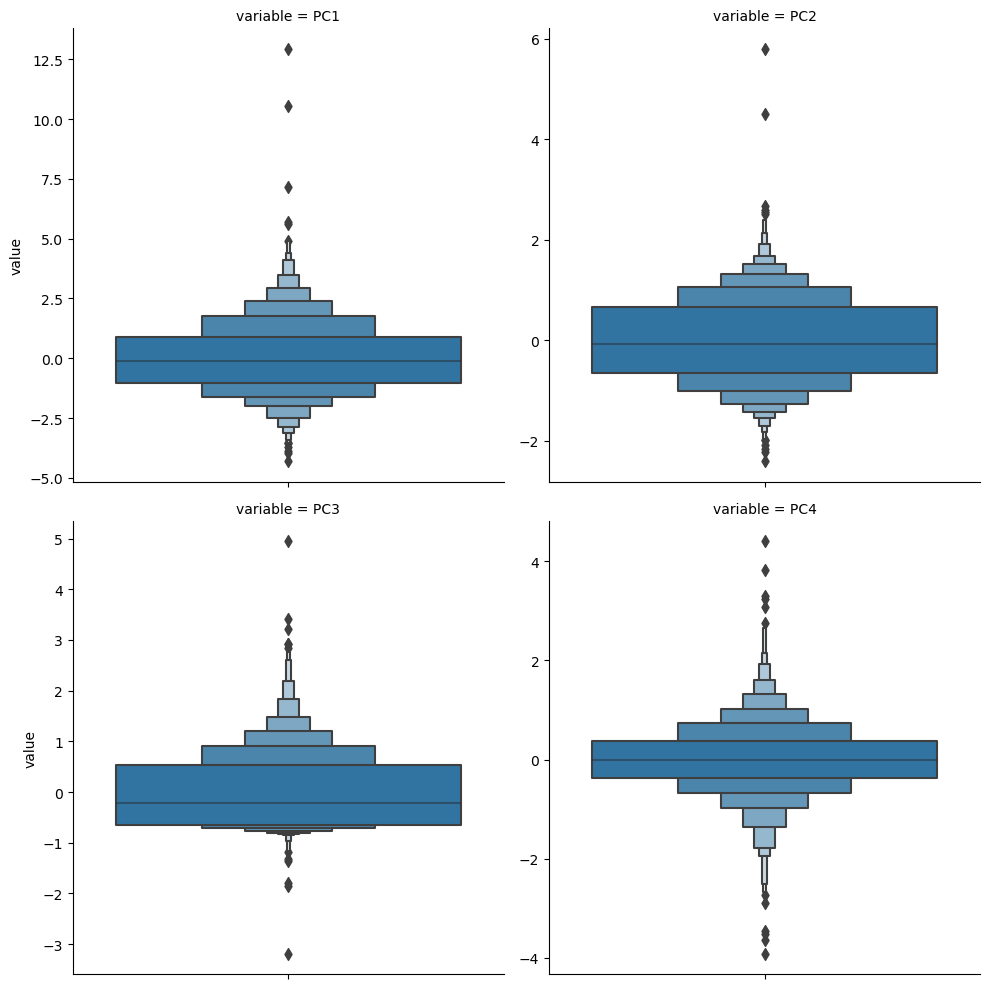

In [70]:
# plot
import seaborn as sns
sns.catplot(
  y='value',
  col='variable',
  data=X_pca.melt(),
  kind='boxen',
  sharey=False,
  col_wrap=2
)

In [77]:
# Outliers
idxs = X_pca['PC1'].sort_values(ascending=False).index
df.loc[idxs, ['SalePrice', 'Neighborhood', 'SaleCondition'] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
2180,183850,Edwards,Partial,1154.0,2009,5095.0,5095.0
2181,184750,Edwards,Partial,884.0,2008,3138.0,4676.0
1760,745000,Northridge,Abnorml,813.0,1996,2396.0,4476.0
1767,755000,Northridge,Normal,832.0,1995,2444.0,4316.0
...,...,...,...,...,...,...,...
662,59000,Old_Town,Normal,0.0,1950,416.0,599.0
2679,80500,Brookside,Normal,0.0,1950,0.0,912.0
2879,51689,Iowa_DOT_and_Rail_Road,Abnorml,0.0,1950,0.0,729.0
780,63900,Sawyer,Normal,0.0,1950,0.0,660.0


In [ ]:
# Outlier detection
